In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import scipy
from scipy.optimize import curve_fit
import seaborn as sns
from matplotlib import cm
import csv
import scipy.io as sio
import pandas as pd
from scipy.special import erf
import time
import torch
import os
import h5py
from scipy.special import k0

# plotting configuration
ratio = 1.7
figure_len, figure_width = 24*ratio, 18*ratio
title_font_size = 12*ratio
font_size_1, font_size_2 = 9*ratio, 9*ratio
legend_size = 18*ratio
line_width, tick_len = ratio, 4*ratio
marker_size = 5*ratio
plot_line_width = 2*ratio
hfont = {'fontname': 'Arial'}
marker_edge_width = 4
pal = sns.color_palette("deep")
sns.set(style='ticks')

### Fig. S5 - plot individual currents for all stimulus sizes

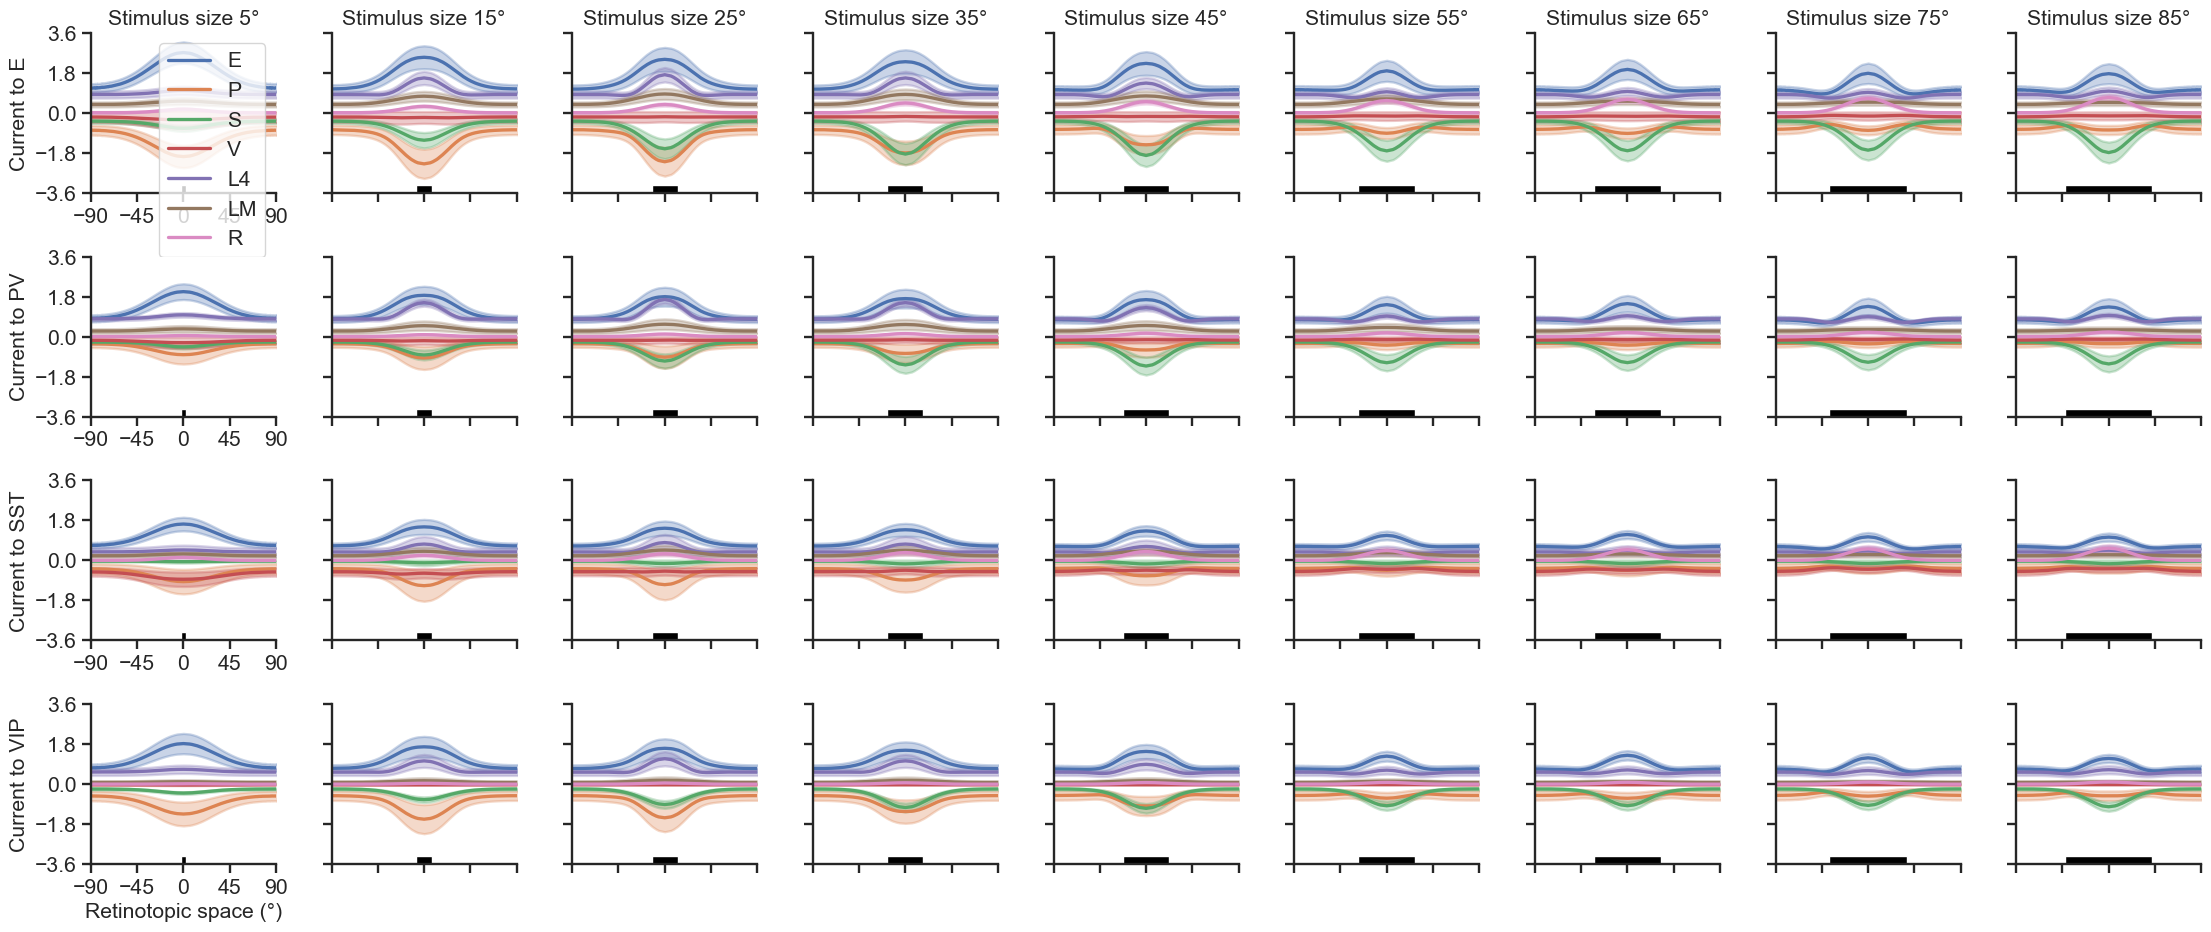

In [2]:
def calc_distance(i, j):
    """calculate the distance between two neurons,
        i and j are the indices of two neurons, i and j are from 0 to N*N-1 (31*30),
        x1 and y1 are the coordinate for the first neuron, x1 and y1 are from 0 to 30.
    """
    x1, y1 = divmod(i, N)
    x2, y2 = divmod(j, N)

    xd = np.minimum(np.abs(x1 - x2), N - np.abs(x1 - x2))
    yd = np.minimum(np.abs(y1 - y2), N - np.abs(y1 - y2))
    return np.sqrt(xd**2 + yd**2)

N = 30
center = int(((N+1)*N)/2) # index of the center
distances_to_center = np.array([calc_distance(i, center) for i in range(N * N)]) # calculate the distance between every point in the 2D grid and the center
sorted_distance_indices = np.argsort(distances_to_center) # indices of the sorted distance in the original array
sorted_distances = distances_to_center[sorted_distance_indices] # the sorted distances
sorted_distances_degree = sorted_distances*6 # the sorted distances in degree

sorted_distances_degree = np.asarray(sorted_distances_degree)  # your input array
unique_sorted_distances_degree, unique_indices = np.unique(sorted_distances_degree, return_index=True)

unique_sorted_distances_degree_left = -unique_sorted_distances_degree[::-1]
unique_sorted_distances_degree_total = list(unique_sorted_distances_degree_left[:-1]) + list(unique_sorted_distances_degree)
unique_sorted_distances_degree_total = np.asarray(unique_sorted_distances_degree_total)

l_config = ['final_gaussian_classical']
l_stimulus = [0, 5, 15, 25, 35, 45, 55, 65, 75, 85]
n_stimulus = len(l_stimulus)
l_baseline = sio.loadmat("data/baselines.mat")['baseline']

l_stim_type_index = [0]
l_celltype = ['E', 'PV', 'SST', 'VIP']
l_y_lowerlims = [0, 0, 0, 0]
l_y_upperlims = [3, 10, 6, 3]

for config_idx in range(len(l_config)):
    config = l_config[config_idx]
    folder_path = 'models/optimized_files_' + config + '/'
    model_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f != '.DS_Store']
    sorted_files = sorted(model_names, key=lambda name: float(name.replace('.pt', '')))
    if len(sorted_files) > 10:
        sorted_files = sorted_files[:10]
    sorted_numbers = sorted([float(f.replace('.pt', '')) for f in sorted_files])

    bias_mat = sio.loadmat('data/bias_mat_' + config + '.mat')['bias_mat']
    
    c_E_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan # number in space, number of stimulus, number of postsynaptic cells, number of files
    c_P_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan
    c_S_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan
    c_V_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan
    c_L4_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan
    c_LM_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan
    c_X_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan

    for model_name_idx in range(len(sorted_files)):
        model_name = sorted_files[model_name_idx]
        c_mats = {}   # dict to store the loaded matrices
        with h5py.File("simulation_data/c_mats_" + config + "_" + model_name + ".h5", "r") as f:
            for key in f.keys():
                c_mats[key] = f[key][...]
        
        conn_file_path = folder_path + model_name

        df = pd.read_csv('simulated_rate_fields/' + config + '_response_grid_' +  str(model_name) + '.csv')

        for i in l_stim_type_index:
            s_cond = 'classical' if i == 0 else 'inverse'

            for j in range(4):

                for k in range(n_stimulus):

                    if j == 0:
                        # sort all currents
                        c_EE_sorted = c_mats["c_EE_mat"][sorted_distance_indices]
                        c_EP_sorted = c_mats["c_EP_mat"][sorted_distance_indices]
                        c_ES_sorted = c_mats["c_ES_mat"][sorted_distance_indices]
                        c_EV_sorted = c_mats["c_EV_mat"][sorted_distance_indices]
                        c_EL4_sorted = c_mats["c_EL4_mat"][sorted_distance_indices]
                        c_ELM_sorted = c_mats["c_ELM_mat"][sorted_distance_indices]
                        c_EX_sorted = c_mats["c_EX_mat"][sorted_distance_indices]
                        c_EY_sorted = c_mats["c_EY_mat"][sorted_distance_indices]
                        c_EZ_sorted = c_mats["c_EZ_mat"][sorted_distance_indices]

                        # extract data at unique indices for given k
                        c_E_data = c_EE_sorted[unique_indices, k]
                        c_P_data = c_EP_sorted[unique_indices, k]
                        c_S_data = c_ES_sorted[unique_indices, k]
                        c_V_data = c_EV_sorted[unique_indices, k]
                        c_L4_data = c_EL4_sorted[unique_indices, k]
                        c_LM_data = c_ELM_sorted[unique_indices, k]
                        c_X_data = c_EX_sorted[unique_indices, k]
                        c_Y_data = c_EY_sorted[unique_indices, k]
                        c_Z_data = c_EZ_sorted[unique_indices, k]

                    elif j == 1:
                        # sort all currents
                        c_PE_sorted = c_mats["c_PE_mat"][sorted_distance_indices]
                        c_PP_sorted = c_mats["c_PP_mat"][sorted_distance_indices]
                        c_PS_sorted = c_mats["c_PS_mat"][sorted_distance_indices]
                        c_PV_sorted = c_mats["c_PV_mat"][sorted_distance_indices]
                        c_PL4_sorted = c_mats["c_PL4_mat"][sorted_distance_indices]
                        c_PLM_sorted = c_mats["c_PLM_mat"][sorted_distance_indices]
                        c_PX_sorted = c_mats["c_PX_mat"][sorted_distance_indices]
                        c_PY_sorted = c_mats["c_PY_mat"][sorted_distance_indices]
                        c_PZ_sorted = c_mats["c_PZ_mat"][sorted_distance_indices]

                        # extract data at unique indices for given k
                        c_E_data = c_PE_sorted[unique_indices, k]
                        c_P_data = c_PP_sorted[unique_indices, k]
                        c_S_data = c_PS_sorted[unique_indices, k]
                        c_V_data = c_PV_sorted[unique_indices, k]
                        c_L4_data = c_PL4_sorted[unique_indices, k]
                        c_LM_data = c_PLM_sorted[unique_indices, k]
                        c_X_data = c_PX_sorted[unique_indices, k]
                        c_Y_data = c_PY_sorted[unique_indices, k]
                        c_Z_data = c_PZ_sorted[unique_indices, k]

                    elif j == 2:
                        # sort all currents
                        c_SE_sorted  = c_mats["c_SE_mat" ][sorted_distance_indices]
                        c_SP_sorted  = c_mats["c_SP_mat" ][sorted_distance_indices]
                        c_SS_sorted  = c_mats["c_SS_mat" ][sorted_distance_indices]
                        c_SV_sorted  = c_mats["c_SV_mat" ][sorted_distance_indices]
                        c_SL4_sorted = c_mats["c_SL4_mat"][sorted_distance_indices]
                        c_SLM_sorted = c_mats["c_SLM_mat"][sorted_distance_indices]
                        c_SX_sorted  = c_mats["c_SX_mat" ][sorted_distance_indices]
                        c_SY_sorted  = c_mats["c_SY_mat" ][sorted_distance_indices]
                        c_SZ_sorted  = c_mats["c_SZ_mat" ][sorted_distance_indices]

                        # extract data at unique indices for given k
                        c_E_data  = c_SE_sorted [unique_indices, k]
                        c_P_data  = c_SP_sorted [unique_indices, k]
                        c_S_data  = c_SS_sorted [unique_indices, k]
                        c_V_data  = c_SV_sorted [unique_indices, k]
                        c_L4_data = c_SL4_sorted[unique_indices, k]
                        c_LM_data = c_SLM_sorted[unique_indices, k]
                        c_X_data  = c_SX_sorted [unique_indices, k]
                        c_Y_data  = c_SY_sorted [unique_indices, k]
                        c_Z_data  = c_SZ_sorted [unique_indices, k]

                    else:
                        # sort all currents
                        c_VE_sorted  = c_mats["c_VE_mat" ][sorted_distance_indices]
                        c_VP_sorted  = c_mats["c_VP_mat" ][sorted_distance_indices]
                        c_VS_sorted  = c_mats["c_VS_mat" ][sorted_distance_indices]
                        c_VV_sorted  = c_mats["c_VV_mat" ][sorted_distance_indices]
                        c_VL4_sorted = c_mats["c_VL4_mat"][sorted_distance_indices]
                        c_VLM_sorted = c_mats["c_VLM_mat"][sorted_distance_indices]
                        c_VX_sorted  = c_mats["c_VX_mat" ][sorted_distance_indices]
                        c_VY_sorted  = c_mats["c_VY_mat" ][sorted_distance_indices]
                        c_VZ_sorted  = c_mats["c_VZ_mat" ][sorted_distance_indices]

                        # extract data at unique indices for given k
                        c_E_data  = c_VE_sorted [unique_indices, k]
                        c_P_data  = c_VP_sorted [unique_indices, k]
                        c_S_data  = c_VS_sorted [unique_indices, k]
                        c_V_data  = c_VV_sorted [unique_indices, k]
                        c_L4_data = c_VL4_sorted[unique_indices, k]
                        c_LM_data = c_VLM_sorted[unique_indices, k]
                        c_X_data  = c_VX_sorted [unique_indices, k]
                        c_Y_data  = c_VY_sorted [unique_indices, k]
                        c_Z_data  = c_VZ_sorted [unique_indices, k]


                    c_E_data_left = c_E_data[::-1]
                    c_E_data_total = np.asarray(list(c_E_data_left[:-1]) + list(c_E_data))

                    # For P
                    c_P_data_left = c_P_data[::-1]
                    c_P_data_total = np.asarray(list(c_P_data_left[:-1]) + list(c_P_data))

                    # For S
                    c_S_data_left = c_S_data[::-1]
                    c_S_data_total = np.asarray(list(c_S_data_left[:-1]) + list(c_S_data))

                    # For V
                    c_V_data_left = c_V_data[::-1]
                    c_V_data_total = np.asarray(list(c_V_data_left[:-1]) + list(c_V_data))

                    # For L4
                    c_L4_data_left = c_L4_data[::-1]
                    c_L4_data_total = np.asarray(list(c_L4_data_left[:-1]) + list(c_L4_data))

                    # For LM
                    c_LM_data_left = c_LM_data[::-1]
                    c_LM_data_total = np.asarray(list(c_LM_data_left[:-1]) + list(c_LM_data))

                    # For X
                    c_X_data_left = c_X_data[::-1]
                    c_X_data_total = np.asarray(list(c_X_data_left[:-1]) + list(c_X_data))

                    c_Y_data_left = c_Y_data[::-1]
                    c_Y_data_total = np.asarray(list(c_Y_data_left[:-1]) + list(c_Y_data))

                    # Z
                    c_Z_data_left = c_Z_data[::-1]
                    c_Z_data_total = np.asarray(list(c_Z_data_left[:-1]) + list(c_Z_data))
                    
                    c_E_total[:, k, j, model_name_idx] = c_E_data_total
                    c_P_total[:, k, j, model_name_idx] = c_P_data_total
                    c_S_total[:, k, j, model_name_idx] = c_S_data_total
                    c_V_total[:, k, j, model_name_idx] = c_V_data_total
                    c_L4_total[:, k, j, model_name_idx] = c_L4_data_total
                    c_LM_total[:, k, j, model_name_idx] = c_LM_data_total
                    c_X_total[:, k, j, model_name_idx] = c_X_data_total


    fig, axes = plt.subplots(4, 9, figsize=(22, 9))
    fig.tight_layout()
    
    for j in range(4):

        for k in np.arange(1, 10, 1):

            idx1, idx2 = j, k-1
            axes[idx1, idx2].spines['top'].set_visible(False)
            axes[idx1, idx2].spines['right'].set_visible(False)
            axes[idx1, idx2].spines['bottom'].set_visible(True)
            axes[idx1, idx2].spines['left'].set_visible(True)
            for axis in ['top', 'bottom', 'left', 'right']:
                axes[idx1, idx2].spines[axis].set_linewidth(line_width)
            axes[idx1, idx2].tick_params(width=line_width, length=tick_len)

            axes[idx1, idx2].plot(unique_sorted_distances_degree_total, np.mean(c_E_total[:, k, j, :], axis=1), linewidth=plot_line_width*0.7, color=pal[0])
            axes[idx1, idx2].plot(unique_sorted_distances_degree_total, np.mean(c_P_total[:, k, j, :], axis=1), linewidth=plot_line_width*0.7, color=pal[1])
            axes[idx1, idx2].plot(unique_sorted_distances_degree_total, np.mean(c_S_total[:, k, j, :], axis=1), linewidth=plot_line_width*0.7, color=pal[2])
            axes[idx1, idx2].plot(unique_sorted_distances_degree_total, np.mean(c_V_total[:, k, j, :], axis=1), linewidth=plot_line_width*0.7, color=pal[3])
            axes[idx1, idx2].plot(unique_sorted_distances_degree_total, np.mean(c_L4_total[:, k, j, :], axis=1), linewidth=plot_line_width*0.7, color=pal[4])
            axes[idx1, idx2].plot(unique_sorted_distances_degree_total, np.mean(c_LM_total[:, k, j, :], axis=1), linewidth=plot_line_width*0.7, color=pal[5])
            axes[idx1, idx2].plot(unique_sorted_distances_degree_total, np.mean(c_X_total[:, k, j, :], axis=1), linewidth=plot_line_width*0.7, color=pal[6])
            # axes[idx1, idx2].plot(unique_sorted_distances_degree_total, c_Y_data_total, linewidth=plot_line_width*0.5, color=pal[7])
            # axes[idx1, idx2].plot(unique_sorted_distances_degree_total, c_Z_data_total, linewidth=plot_line_width*0.5, color=pal[8])
            
            c_E_total_std = np.std(c_E_total[:, k, j, :], axis=1)
            c_P_total_std = np.std(c_P_total[:, k, j, :], axis=1)
            c_S_total_std = np.std(c_S_total[:, k, j, :], axis=1)
            c_V_total_std = np.std(c_V_total[:, k, j, :], axis=1)
            c_L4_total_std = np.std(c_L4_total[:, k, j, :], axis=1)
            c_LM_total_std = np.std(c_LM_total[:, k, j, :], axis=1)
            c_X_total_std = np.std(c_X_total[:, k, j, :], axis=1)

            axes[idx1, idx2].fill_between(unique_sorted_distances_degree_total, np.mean(c_E_total[:, k, j, :], axis=1) - c_E_total_std, np.mean(c_E_total[:, k, j, :], axis=1) + c_E_total_std, linewidth=plot_line_width*0.5, color=pal[0], alpha=0.3)
            axes[idx1, idx2].fill_between(unique_sorted_distances_degree_total, np.mean(c_P_total[:, k, j, :], axis=1) - c_P_total_std, np.mean(c_P_total[:, k, j, :], axis=1) + c_P_total_std, linewidth=plot_line_width*0.5, color=pal[1], alpha=0.3)
            axes[idx1, idx2].fill_between(unique_sorted_distances_degree_total, np.mean(c_S_total[:, k, j, :], axis=1) - c_S_total_std, np.mean(c_S_total[:, k, j, :], axis=1) + c_S_total_std, linewidth=plot_line_width*0.5, color=pal[2], alpha=0.3)
            axes[idx1, idx2].fill_between(unique_sorted_distances_degree_total, np.mean(c_V_total[:, k, j, :], axis=1) - c_V_total_std, np.mean(c_V_total[:, k, j, :], axis=1) + c_V_total_std, linewidth=plot_line_width*0.5, color=pal[3], alpha=0.3)
            axes[idx1, idx2].fill_between(unique_sorted_distances_degree_total, np.mean(c_L4_total[:, k, j, :], axis=1) - c_L4_total_std, np.mean(c_L4_total[:, k, j, :], axis=1) + c_L4_total_std, linewidth=plot_line_width*0.5, color=pal[4], alpha=0.3)
            axes[idx1, idx2].fill_between(unique_sorted_distances_degree_total, np.mean(c_LM_total[:, k, j, :], axis=1) - c_LM_total_std, np.mean(c_LM_total[:, k, j, :], axis=1) + c_LM_total_std, linewidth=plot_line_width*0.5, color=pal[5], alpha=0.3)
            axes[idx1, idx2].fill_between(unique_sorted_distances_degree_total, np.mean(c_X_total[:, k, j, :], axis=1) - c_X_total_std, np.mean(c_X_total[:, k, j, :], axis=1) + c_X_total_std, linewidth=plot_line_width*0.5, color=pal[6], alpha=0.3)

            if idx1 == 0:
                axes[idx1, idx2].set_title(f'Stimulus size {l_stimulus[k]}°', fontdict = {'fontname': 'Arial', 'fontsize': font_size_1})
            else:
                pass

            if idx1 == 0 and idx2 == 0:
                axes[idx1, idx2].legend(['E', 'P', 'S', 'V', 'L4', 'LM', 'R'], loc='upper right', prop={"family": "Arial", 'size': font_size_1})

            if idx1 ==3 and idx2 == 0:
                axes[idx1, idx2].set_xlabel('Retinotopic space (°)', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
                
            if idx2 == 0:
                axes[idx1, idx2].set_ylabel('Current to ' + l_celltype[j], fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
            else:
                axes[idx1, idx2].set_xticklabels([])
                axes[idx1, idx2].set_yticklabels([])

                
            axes[idx1, idx2].set_xlim(-90, 90)
            axes[idx1, idx2].set_xticks([-90, -45, 0, 45, 90])

            axes[idx1, idx2].set_yticks([-3.6, -1.8, 0, 1.8, 3.6])
            axes[idx1, idx2].set_ylim(-3.6, 3.6)

            axes[idx1, idx2].tick_params(axis='both', which='major', labelsize=font_size_1)  # Customize tick label font size

            y_limits = axes[idx1, idx2].get_ylim()
            if i == 0:
                rect = matplotlib.patches.Rectangle((-l_stimulus[k]/2, y_limits[0]), l_stimulus[k], (y_limits[1]-y_limits[0])/20, linewidth=1, edgecolor=None, facecolor='black', alpha=1)
            else:
                rect = matplotlib.patches.Rectangle((-l_stimulus[k]/2, y_limits[0]), l_stimulus[k], (y_limits[1]-y_limits[0])/20, linewidth=1, edgecolor=None, facecolor='red', alpha=1)

            axes[idx1, idx2].add_patch(rect)    

            for label in (axes[idx1, idx2].get_xticklabels() + axes[idx1, idx2].get_yticklabels()):
                label.set_fontname('Arial')

            fig.subplots_adjust(hspace=0.4, wspace=0.3)
#             title_font_size = 16

            # fig.savefig('paper_figures/paper_png/Fig_currents_all.png', bbox_inches='tight', dpi=300)
            # fig.savefig('paper_figures/paper_pdf/Fig_currents_all.pdf', bbox_inches='tight')

### Fig. 3A and 3B - plot current examples for E

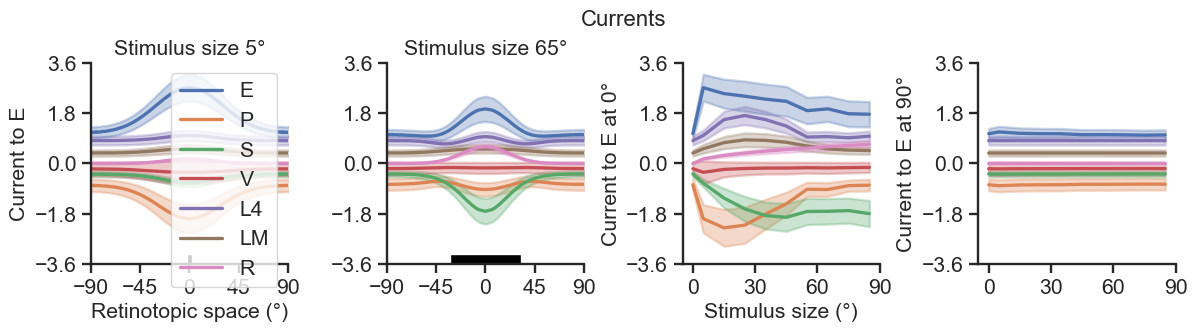

In [3]:
l_stimulus = [0, 5, 15, 25, 35, 45, 55, 65, 75, 85]
n_stimulus = len(l_stimulus)
l_baseline = sio.loadmat("data/baselines.mat")['baseline']

l_celltype = ['E', 'PV', 'SST', 'VIP']
l_y_lowerlims = [0, 0, 0, 0]
l_y_upperlims = [3, 10, 6, 3]

l_selected_stimulus_idx = [1, 7]
center_index = np.where(unique_sorted_distances_degree == 0)[0][0] + 119
surr_index = np.where(unique_sorted_distances_degree == 90)[0][0] + 119

for config_idx in range(len(l_config)):
    config = l_config[config_idx]
    folder_path = 'models/optimized_files_' + config + '/'
    model_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f != '.DS_Store']
    sorted_files = sorted(model_names, key=lambda name: float(name.replace('.pt', '')))
    if len(sorted_files) > 10:
        sorted_files = sorted_files[:10]
    sorted_numbers = sorted([float(f.replace('.pt', '')) for f in sorted_files])

    bias_mat = sio.loadmat('data/bias_mat_' + config + '.mat')['bias_mat']
    
    c_E_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan # number in space, number of stimulus, number of postsynaptic cells, number of files
    c_P_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan
    c_S_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan
    c_V_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan
    c_L4_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan
    c_LM_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan
    c_X_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan

    for model_name_idx in range(len(sorted_files)):
        model_name = sorted_files[model_name_idx]
        c_mats = {}   # dict to store the loaded matrices
        with h5py.File("simulation_data/c_mats_" + config + "_" + model_name + ".h5", "r") as f:
            for key in f.keys():
                c_mats[key] = f[key][...]
        
        conn_file_path = folder_path + model_name

        for i in l_stim_type_index:
            s_cond = 'classical' if i == 0 else 'inverse'

            for j in range(4):

                for k in range(n_stimulus):

                    if j == 0:

                        # sort all currents
                        c_EE_sorted = c_mats["c_EE_mat"][sorted_distance_indices]
                        c_EP_sorted = c_mats["c_EP_mat"][sorted_distance_indices]
                        c_ES_sorted = c_mats["c_ES_mat"][sorted_distance_indices]
                        c_EV_sorted = c_mats["c_EV_mat"][sorted_distance_indices]
                        c_EL4_sorted = c_mats["c_EL4_mat"][sorted_distance_indices]
                        c_ELM_sorted = c_mats["c_ELM_mat"][sorted_distance_indices]
                        c_EX_sorted = c_mats["c_EX_mat"][sorted_distance_indices]
                        c_EY_sorted = c_mats["c_EY_mat"][sorted_distance_indices]
                        c_EZ_sorted = c_mats["c_EZ_mat"][sorted_distance_indices]

                        # extract data at unique indices for given k
                        c_E_data = c_EE_sorted[unique_indices, k]
                        c_P_data = c_EP_sorted[unique_indices, k]
                        c_S_data = c_ES_sorted[unique_indices, k]
                        c_V_data = c_EV_sorted[unique_indices, k]
                        c_L4_data = c_EL4_sorted[unique_indices, k]
                        c_LM_data = c_ELM_sorted[unique_indices, k]
                        c_X_data = c_EX_sorted[unique_indices, k]
                        c_Y_data = c_EY_sorted[unique_indices, k]
                        c_Z_data = c_EZ_sorted[unique_indices, k]

                    elif j == 1:
                        rate_field_sim_data = df[(df['cell_type'] == 'PV') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values
                        # sort all currents
                        c_PE_sorted = c_mats["c_PE_mat"][sorted_distance_indices]
                        c_PP_sorted = c_mats["c_PP_mat"][sorted_distance_indices]
                        c_PS_sorted = c_mats["c_PS_mat"][sorted_distance_indices]
                        c_PV_sorted = c_mats["c_PV_mat"][sorted_distance_indices]
                        c_PL4_sorted = c_mats["c_PL4_mat"][sorted_distance_indices]
                        c_PLM_sorted = c_mats["c_PLM_mat"][sorted_distance_indices]
                        c_PX_sorted = c_mats["c_PX_mat"][sorted_distance_indices]
                        c_PY_sorted = c_mats["c_PY_mat"][sorted_distance_indices]
                        c_PZ_sorted = c_mats["c_PZ_mat"][sorted_distance_indices]

                        # extract data at unique indices for given k
                        c_E_data = c_PE_sorted[unique_indices, k]
                        c_P_data = c_PP_sorted[unique_indices, k]
                        c_S_data = c_PS_sorted[unique_indices, k]
                        c_V_data = c_PV_sorted[unique_indices, k]
                        c_L4_data = c_PL4_sorted[unique_indices, k]
                        c_LM_data = c_PLM_sorted[unique_indices, k]
                        c_X_data = c_PX_sorted[unique_indices, k]
                        c_Y_data = c_PY_sorted[unique_indices, k]
                        c_Z_data = c_PZ_sorted[unique_indices, k]

                    elif j == 2:
                        rate_field_sim_data = df[(df['cell_type'] == 'SST') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values
                        # sort all currents
                        c_SE_sorted  = c_mats["c_SE_mat" ][sorted_distance_indices]
                        c_SP_sorted  = c_mats["c_SP_mat" ][sorted_distance_indices]
                        c_SS_sorted  = c_mats["c_SS_mat" ][sorted_distance_indices]
                        c_SV_sorted  = c_mats["c_SV_mat" ][sorted_distance_indices]
                        c_SL4_sorted = c_mats["c_SL4_mat"][sorted_distance_indices]
                        c_SLM_sorted = c_mats["c_SLM_mat"][sorted_distance_indices]
                        c_SX_sorted  = c_mats["c_SX_mat" ][sorted_distance_indices]
                        c_SY_sorted  = c_mats["c_SY_mat" ][sorted_distance_indices]
                        c_SZ_sorted  = c_mats["c_SZ_mat" ][sorted_distance_indices]

                        # extract data at unique indices for given k
                        c_E_data  = c_SE_sorted [unique_indices, k]
                        c_P_data  = c_SP_sorted [unique_indices, k]
                        c_S_data  = c_SS_sorted [unique_indices, k]
                        c_V_data  = c_SV_sorted [unique_indices, k]
                        c_L4_data = c_SL4_sorted[unique_indices, k]
                        c_LM_data = c_SLM_sorted[unique_indices, k]
                        c_X_data  = c_SX_sorted [unique_indices, k]
                        c_Y_data  = c_SY_sorted [unique_indices, k]
                        c_Z_data  = c_SZ_sorted [unique_indices, k]

                    else:
                        rate_field_sim_data = df[(df['cell_type'] == 'VIP') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values

                        # sort all currents
                        c_VE_sorted  = c_mats["c_VE_mat" ][sorted_distance_indices]
                        c_VP_sorted  = c_mats["c_VP_mat" ][sorted_distance_indices]
                        c_VS_sorted  = c_mats["c_VS_mat" ][sorted_distance_indices]
                        c_VV_sorted  = c_mats["c_VV_mat" ][sorted_distance_indices]
                        c_VL4_sorted = c_mats["c_VL4_mat"][sorted_distance_indices]
                        c_VLM_sorted = c_mats["c_VLM_mat"][sorted_distance_indices]
                        c_VX_sorted  = c_mats["c_VX_mat" ][sorted_distance_indices]
                        c_VY_sorted  = c_mats["c_VY_mat" ][sorted_distance_indices]
                        c_VZ_sorted  = c_mats["c_VZ_mat" ][sorted_distance_indices]

                        # extract data at unique indices for given k
                        c_E_data  = c_VE_sorted [unique_indices, k]
                        c_P_data  = c_VP_sorted [unique_indices, k]
                        c_S_data  = c_VS_sorted [unique_indices, k]
                        c_V_data  = c_VV_sorted [unique_indices, k]
                        c_L4_data = c_VL4_sorted[unique_indices, k]
                        c_LM_data = c_VLM_sorted[unique_indices, k]
                        c_X_data  = c_VX_sorted [unique_indices, k]
                        c_Y_data  = c_VY_sorted [unique_indices, k]
                        c_Z_data  = c_VZ_sorted [unique_indices, k]

                    c_E_data_left = c_E_data[::-1]
                    c_E_data_total = np.asarray(list(c_E_data_left[:-1]) + list(c_E_data))

                    # For P
                    c_P_data_left = c_P_data[::-1]
                    c_P_data_total = np.asarray(list(c_P_data_left[:-1]) + list(c_P_data))
                    

                    # For S
                    c_S_data_left = c_S_data[::-1]
                    c_S_data_total = np.asarray(list(c_S_data_left[:-1]) + list(c_S_data))

                    # For V
                    c_V_data_left = c_V_data[::-1]
                    c_V_data_total = np.asarray(list(c_V_data_left[:-1]) + list(c_V_data))

                    # For L4
                    c_L4_data_left = c_L4_data[::-1]
                    c_L4_data_total = np.asarray(list(c_L4_data_left[:-1]) + list(c_L4_data))

                    # For LM
                    c_LM_data_left = c_LM_data[::-1]
                    c_LM_data_total = np.asarray(list(c_LM_data_left[:-1]) + list(c_LM_data))

                    # For X
                    c_X_data_left = c_X_data[::-1]
                    c_X_data_total = np.asarray(list(c_X_data_left[:-1]) + list(c_X_data))

                    c_Y_data_left = c_Y_data[::-1]
                    c_Y_data_total = np.asarray(list(c_Y_data_left[:-1]) + list(c_Y_data))

                    # Z
                    c_Z_data_left = c_Z_data[::-1]
                    c_Z_data_total = np.asarray(list(c_Z_data_left[:-1]) + list(c_Z_data))
                    
                    c_E_total[:, k, j, model_name_idx] = c_E_data_total
                    c_P_total[:, k, j, model_name_idx] = c_P_data_total
                    c_S_total[:, k, j, model_name_idx] = c_S_data_total
                    c_V_total[:, k, j, model_name_idx] = c_V_data_total
                    c_L4_total[:, k, j, model_name_idx] = c_L4_data_total
                    c_LM_total[:, k, j, model_name_idx] = c_LM_data_total
                    c_X_total[:, k, j, model_name_idx] = c_X_data_total

    fig, axes = plt.subplots(1, 4, figsize=(13*0.9, 3*0.9))
    fig.tight_layout()
    
    for j in range(1):

        for m in range(len(l_selected_stimulus_idx)):
            
            k = l_selected_stimulus_idx[m]
            idx = m
            axes[idx].spines['top'].set_visible(False)
            axes[idx].spines['right'].set_visible(False)
            axes[idx].spines['bottom'].set_visible(True)
            axes[idx].spines['left'].set_visible(True)
            for axis in ['top', 'bottom', 'left', 'right']:
                axes[idx].spines[axis].set_linewidth(line_width)
            axes[idx].tick_params(width=line_width, length=tick_len)

            axes[idx].plot(unique_sorted_distances_degree_total, np.mean(c_E_total[:, k, j, :], axis=1), linewidth=plot_line_width*0.7, color=pal[0])
            axes[idx].plot(unique_sorted_distances_degree_total, np.mean(c_P_total[:, k, j, :], axis=1), linewidth=plot_line_width*0.7, color=pal[1])
            axes[idx].plot(unique_sorted_distances_degree_total, np.mean(c_S_total[:, k, j, :], axis=1), linewidth=plot_line_width*0.7, color=pal[2])
            axes[idx].plot(unique_sorted_distances_degree_total, np.mean(c_V_total[:, k, j, :], axis=1), linewidth=plot_line_width*0.7, color=pal[3])
            axes[idx].plot(unique_sorted_distances_degree_total, np.mean(c_L4_total[:, k, j, :], axis=1), linewidth=plot_line_width*0.7, color=pal[4])
            axes[idx].plot(unique_sorted_distances_degree_total, np.mean(c_LM_total[:, k, j, :], axis=1), linewidth=plot_line_width*0.7, color=pal[5])
            axes[idx].plot(unique_sorted_distances_degree_total, np.mean(c_X_total[:, k, j, :], axis=1), linewidth=plot_line_width*0.7, color=pal[6])

            c_E_total_std = np.std(c_E_total[:, k, j, :], axis=1)
            c_P_total_std = np.std(c_P_total[:, k, j, :], axis=1)
            c_S_total_std = np.std(c_S_total[:, k, j, :], axis=1)
            c_V_total_std = np.std(c_V_total[:, k, j, :], axis=1)
            c_L4_total_std = np.std(c_L4_total[:, k, j, :], axis=1)
            c_LM_total_std = np.std(c_LM_total[:, k, j, :], axis=1)
            c_X_total_std = np.std(c_X_total[:, k, j, :], axis=1)

            axes[idx].fill_between(unique_sorted_distances_degree_total, np.mean(c_E_total[:, k, j, :], axis=1) - c_E_total_std, np.mean(c_E_total[:, k, j, :], axis=1) + c_E_total_std, linewidth=plot_line_width*0.5, color=pal[0], alpha=0.3)
            axes[idx].fill_between(unique_sorted_distances_degree_total, np.mean(c_P_total[:, k, j, :], axis=1) - c_P_total_std, np.mean(c_P_total[:, k, j, :], axis=1) + c_P_total_std, linewidth=plot_line_width*0.5, color=pal[1], alpha=0.3)
            axes[idx].fill_between(unique_sorted_distances_degree_total, np.mean(c_S_total[:, k, j, :], axis=1) - c_S_total_std, np.mean(c_S_total[:, k, j, :], axis=1) + c_S_total_std, linewidth=plot_line_width*0.5, color=pal[2], alpha=0.3)
            axes[idx].fill_between(unique_sorted_distances_degree_total, np.mean(c_V_total[:, k, j, :], axis=1) - c_V_total_std, np.mean(c_V_total[:, k, j, :], axis=1) + c_V_total_std, linewidth=plot_line_width*0.5, color=pal[3], alpha=0.3)
            axes[idx].fill_between(unique_sorted_distances_degree_total, np.mean(c_L4_total[:, k, j, :], axis=1) - c_L4_total_std, np.mean(c_L4_total[:, k, j, :], axis=1) + c_L4_total_std, linewidth=plot_line_width*0.5, color=pal[4], alpha=0.3)
            axes[idx].fill_between(unique_sorted_distances_degree_total, np.mean(c_LM_total[:, k, j, :], axis=1) - c_LM_total_std, np.mean(c_LM_total[:, k, j, :], axis=1) + c_LM_total_std, linewidth=plot_line_width*0.5, color=pal[5], alpha=0.3)
            axes[idx].fill_between(unique_sorted_distances_degree_total, np.mean(c_X_total[:, k, j, :], axis=1) - c_X_total_std, np.mean(c_X_total[:, k, j, :], axis=1) + c_X_total_std, linewidth=plot_line_width*0.5, color=pal[6], alpha=0.3)

            axes[idx].set_title(f'Stimulus size {l_stimulus[k]}°', fontdict = {'fontname': 'Arial', 'fontsize': font_size_1})

            if idx == 0:
                axes[idx].legend(['E', 'P', 'S', 'V', 'L4', 'LM', 'R'], loc='upper right', prop={"family": "Arial", 'size': font_size_1})

            if idx == 0:
                axes[idx].set_xlabel('Retinotopic space (°)', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
                
            if idx == 0:
                axes[idx].set_ylabel('Current to ' + l_celltype[j], fontdict={'fontname': 'Arial', 'fontsize': font_size_1})

            axes[idx].set_xlim(-90, 90)
            axes[idx].set_xticks([-90, -45, 0, 45, 90])

            axes[idx].set_yticks([-3.6, -1.8, 0, 1.8, 3.6])
            axes[idx].set_ylim(-3.6, 3.6)

            axes[idx].tick_params(axis='both', which='major', labelsize=font_size_1)  # Customize tick label font size

            y_limits = axes[idx].get_ylim()
            if i == 0:
                rect = matplotlib.patches.Rectangle((-l_stimulus[k]/2, y_limits[0]), l_stimulus[k], (y_limits[1]-y_limits[0])/20, linewidth=1, edgecolor=None, facecolor='black', alpha=1)
            else:
                rect = matplotlib.patches.Rectangle((-l_stimulus[k]/2, y_limits[0]), l_stimulus[k], (y_limits[1]-y_limits[0])/20, linewidth=1, edgecolor=None, facecolor='red', alpha=1)

            axes[idx].add_patch(rect)    

            for label in (axes[idx].get_xticklabels() + axes[idx].get_yticklabels()):
                label.set_fontname('Arial')

    for m in range(2):
        idx = m+2

        axes[idx].spines['top'].set_visible(False)
        axes[idx].spines['right'].set_visible(False)
        axes[idx].spines['bottom'].set_visible(True)
        axes[idx].spines['left'].set_visible(True)
        for axis in ['top', 'bottom', 'left', 'right']:
            axes[idx].spines[axis].set_linewidth(line_width)
        axes[idx].tick_params(width=line_width, length=tick_len)

        if m == 0:
            c_E_std = np.std(c_E_total[center_index, :, 0, :], axis=1)
            c_P_std = np.std(c_P_total[center_index, :, 0, :], axis=1)
            c_S_std = np.std(c_S_total[center_index, :, 0, :], axis=1)
            c_V_std = np.std(c_V_total[center_index, :, 0, :], axis=1)
            c_L4_std = np.std(c_L4_total[center_index, :, 0, :], axis=1)
            c_LM_std = np.std(c_LM_total[center_index, :, 0, :], axis=1)
            c_X_std = np.std(c_X_total[center_index, :, 0, :], axis=1)

            axes[idx].plot(l_stimulus, np.mean(c_E_total[center_index, :, 0, :], axis=1), linewidth=plot_line_width*0.7, color=pal[0])
            axes[idx].plot(l_stimulus, np.mean(c_P_total[center_index, :, 0, :], axis=1), linewidth=plot_line_width*0.7, color=pal[1])
            axes[idx].plot(l_stimulus, np.mean(c_S_total[center_index, :, 0, :], axis=1), linewidth=plot_line_width*0.7, color=pal[2])
            axes[idx].plot(l_stimulus, np.mean(c_V_total[center_index, :, 0, :], axis=1), linewidth=plot_line_width*0.7, color=pal[3])
            axes[idx].plot(l_stimulus, np.mean(c_L4_total[center_index, :, 0, :], axis=1), linewidth=plot_line_width*0.7, color=pal[4])
            axes[idx].plot(l_stimulus, np.mean(c_LM_total[center_index, :, 0, :], axis=1), linewidth=plot_line_width*0.7, color=pal[5])
            axes[idx].plot(l_stimulus, np.mean(c_X_total[center_index, :, 0, :], axis=1), linewidth=plot_line_width*0.7, color=pal[6])

            # Compute means once for the shading
            c_E_mean  = np.mean(c_E_total[center_index, :, 0, :], axis=1)
            c_P_mean  = np.mean(c_P_total[center_index, :, 0, :], axis=1)
            c_S_mean  = np.mean(c_S_total[center_index, :, 0, :], axis=1)
            c_V_mean  = np.mean(c_V_total[center_index, :, 0, :], axis=1)
            c_L4_mean = np.mean(c_L4_total[center_index, :, 0, :], axis=1)
            c_LM_mean = np.mean(c_LM_total[center_index, :, 0, :], axis=1)
            c_X_mean  = np.mean(c_X_total[center_index, :, 0, :], axis=1)
            
            axes[idx].fill_between(l_stimulus, c_E_mean  - c_E_std,  c_E_mean  + c_E_std,
                                   linewidth=plot_line_width*0.5, color=pal[0], alpha=0.3)
            axes[idx].fill_between(l_stimulus, c_P_mean  - c_P_std,  c_P_mean  + c_P_std,
                                   linewidth=plot_line_width*0.5, color=pal[1], alpha=0.3)
            axes[idx].fill_between(l_stimulus, c_S_mean  - c_S_std,  c_S_mean  + c_S_std,
                                   linewidth=plot_line_width*0.5, color=pal[2], alpha=0.3)
            axes[idx].fill_between(l_stimulus, c_V_mean  - c_V_std,  c_V_mean  + c_V_std,
                                   linewidth=plot_line_width*0.5, color=pal[3], alpha=0.3)
            axes[idx].fill_between(l_stimulus, c_L4_mean - c_L4_std, c_L4_mean + c_L4_std,
                                   linewidth=plot_line_width*0.5, color=pal[4], alpha=0.3)
            axes[idx].fill_between(l_stimulus, c_LM_mean - c_LM_std, c_LM_mean + c_LM_std,
                                   linewidth=plot_line_width*0.5, color=pal[5], alpha=0.3)
            axes[idx].fill_between(l_stimulus, c_X_mean  - c_X_std,  c_X_mean  + c_X_std,
                                   linewidth=plot_line_width*0.5, color=pal[6], alpha=0.3)

        else:
            # Standard deviations at surround
            c_E_std  = np.std(c_E_total[surr_index, :, 0, :], axis=1)
            c_P_std  = np.std(c_P_total[surr_index, :, 0, :], axis=1)
            c_S_std  = np.std(c_S_total[surr_index, :, 0, :], axis=1)
            c_V_std  = np.std(c_V_total[surr_index, :, 0, :], axis=1)
            c_L4_std = np.std(c_L4_total[surr_index, :, 0, :], axis=1)
            c_LM_std = np.std(c_LM_total[surr_index, :, 0, :], axis=1)
            c_X_std  = np.std(c_X_total[surr_index, :, 0, :], axis=1)

            # Plot means using surround index
            axes[idx].plot(l_stimulus, np.mean(c_E_total[surr_index, :, 0, :], axis=1),
                           linewidth=plot_line_width*0.7, color=pal[0])
            axes[idx].plot(l_stimulus, np.mean(c_P_total[surr_index, :, 0, :], axis=1),
                           linewidth=plot_line_width*0.7, color=pal[1])
            axes[idx].plot(l_stimulus, np.mean(c_S_total[surr_index, :, 0, :], axis=1),
                           linewidth=plot_line_width*0.7, color=pal[2])
            axes[idx].plot(l_stimulus, np.mean(c_V_total[surr_index, :, 0, :], axis=1),
                           linewidth=plot_line_width*0.7, color=pal[3])
            axes[idx].plot(l_stimulus, np.mean(c_L4_total[surr_index, :, 0, :], axis=1),
                           linewidth=plot_line_width*0.7, color=pal[4])
            axes[idx].plot(l_stimulus, np.mean(c_LM_total[surr_index, :, 0, :], axis=1),
                           linewidth=plot_line_width*0.7, color=pal[5])
            axes[idx].plot(l_stimulus, np.mean(c_X_total[surr_index, :, 0, :], axis=1),
                           linewidth=plot_line_width*0.7, color=pal[6])

            # Compute means once for the shading
            c_E_mean  = np.mean(c_E_total[surr_index, :, 0, :], axis=1)
            c_P_mean  = np.mean(c_P_total[surr_index, :, 0, :], axis=1)
            c_S_mean  = np.mean(c_S_total[surr_index, :, 0, :], axis=1)
            c_V_mean  = np.mean(c_V_total[surr_index, :, 0, :], axis=1)
            c_L4_mean = np.mean(c_L4_total[surr_index, :, 0, :], axis=1)
            c_LM_mean = np.mean(c_LM_total[surr_index, :, 0, :], axis=1)
            c_X_mean  = np.mean(c_X_total[surr_index, :, 0, :], axis=1)

            # Shaded error bands (mean ± std)
            axes[idx].fill_between(l_stimulus, c_E_mean  - c_E_std,  c_E_mean  + c_E_std,
                                   linewidth=plot_line_width*0.5, color=pal[0], alpha=0.3)
            axes[idx].fill_between(l_stimulus, c_P_mean  - c_P_std,  c_P_mean  + c_P_std,
                                   linewidth=plot_line_width*0.5, color=pal[1], alpha=0.3)
            axes[idx].fill_between(l_stimulus, c_S_mean  - c_S_std,  c_S_mean  + c_S_std,
                                   linewidth=plot_line_width*0.5, color=pal[2], alpha=0.3)
            axes[idx].fill_between(l_stimulus, c_V_mean  - c_V_std,  c_V_mean  + c_V_std,
                                   linewidth=plot_line_width*0.5, color=pal[3], alpha=0.3)
            axes[idx].fill_between(l_stimulus, c_L4_mean - c_L4_std, c_L4_mean + c_L4_std,
                                   linewidth=plot_line_width*0.5, color=pal[4], alpha=0.3)
            axes[idx].fill_between(l_stimulus, c_LM_mean - c_LM_std, c_LM_mean + c_LM_std,
                                   linewidth=plot_line_width*0.5, color=pal[5], alpha=0.3)
            axes[idx].fill_between(l_stimulus, c_X_mean  - c_X_std,  c_X_mean  + c_X_std,
                                   linewidth=plot_line_width*0.5, color=pal[6], alpha=0.3)

        if idx1 == 0:
            axes[idx1, idx2].set_title(f'Stimulus size {l_stimulus[k]}°', fontdict = {'fontname': 'Arial', 'fontsize': font_size_1})
        else:
            pass
            
        if idx == 2:
            axes[idx].set_xlabel('Stimulus size (°)', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})

        if idx == 2:
            axes[idx].set_ylabel('Current to E at 0°', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
        else:
            axes[idx].set_ylabel('Current to E at 90°', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})

        axes[idx].set_xlim(-5, 90)
        axes[idx].set_xticks([0, 30, 60, 90])

        axes[idx].set_yticks([-3.6, -1.8, 0, 1.8, 3.6])
        axes[idx].set_ylim(-3.6, 3.6)

        axes[idx].tick_params(axis='both', which='major', labelsize=font_size_1)  # Customize tick label font size

        for label in (axes[idx].get_xticklabels() + axes[idx].get_yticklabels()):
            label.set_fontname('Arial')

    fig.subplots_adjust(hspace=0.4, wspace=0.5)
    title_font_size = 16
    fig.suptitle('Currents', y=1.11, fontsize=title_font_size, fontname='Arial')

    # fig.savefig('paper_figures/paper_png/Fig_currents.png', bbox_inches='tight', dpi=300)

### Fig. S6 - plot current examples for PV, SST, and VIP

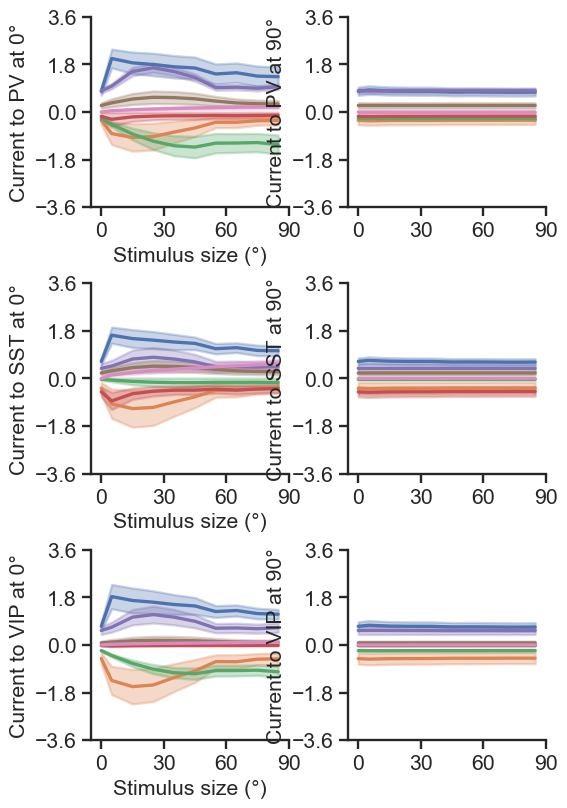

In [4]:
l_stimulus = [0, 5, 15, 25, 35, 45, 55, 65, 75, 85]
n_stimulus = len(l_stimulus)
l_baseline = sio.loadmat("data/baselines.mat")['baseline']

l_celltype = ['E', 'PV', 'SST', 'VIP']
l_y_lowerlims = [0, 0, 0, 0]
l_y_upperlims = [3, 10, 6, 3]

l_selected_stimulus_idx = [1, 7]
center_index = np.where(unique_sorted_distances_degree == 0)[0][0] + 119
surr_index = np.where(unique_sorted_distances_degree == 90)[0][0] + 119

for config_idx in range(len(l_config)):
    config = l_config[config_idx]
    folder_path = 'models/optimized_files_' + config + '/'
    model_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f != '.DS_Store']
    sorted_files = sorted(model_names, key=lambda name: float(name.replace('.pt', '')))
    if len(sorted_files) > 10:
        sorted_files = sorted_files[:10]
    sorted_numbers = sorted([float(f.replace('.pt', '')) for f in sorted_files])

    bias_mat = sio.loadmat('data/bias_mat_' + config + '.mat')['bias_mat']
    
    c_E_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan # number in space, number of stimulus, number of postsynaptic cells, number of files
    c_P_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan
    c_S_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan
    c_V_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan
    c_L4_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan
    c_LM_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan
    c_X_total = np.zeros((239, 10, 4, len(sorted_files))) * np.nan

    for model_name_idx in range(len(sorted_files)):
        model_name = sorted_files[model_name_idx]
        c_mats = {}   # dict to store the loaded matrices
        with h5py.File("simulation_data/c_mats_" + config + "_" + model_name + ".h5", "r") as f:
            for key in f.keys():
                c_mats[key] = f[key][...]
        
        conn_file_path = folder_path + model_name

        for i in l_stim_type_index:
            s_cond = 'classical' if i == 0 else 'inverse'

            for j in range(4):

                for k in range(n_stimulus):

                    if j == 0:
             
                        # sort all currents
                        c_EE_sorted = c_mats["c_EE_mat"][sorted_distance_indices]
                        c_EP_sorted = c_mats["c_EP_mat"][sorted_distance_indices]
                        c_ES_sorted = c_mats["c_ES_mat"][sorted_distance_indices]
                        c_EV_sorted = c_mats["c_EV_mat"][sorted_distance_indices]
                        c_EL4_sorted = c_mats["c_EL4_mat"][sorted_distance_indices]
                        c_ELM_sorted = c_mats["c_ELM_mat"][sorted_distance_indices]
                        c_EX_sorted = c_mats["c_EX_mat"][sorted_distance_indices]
                        c_EY_sorted = c_mats["c_EY_mat"][sorted_distance_indices]
                        c_EZ_sorted = c_mats["c_EZ_mat"][sorted_distance_indices]

                        # extract data at unique indices for given k
                        c_E_data = c_EE_sorted[unique_indices, k]
                        c_P_data = c_EP_sorted[unique_indices, k]
                        c_S_data = c_ES_sorted[unique_indices, k]
                        c_V_data = c_EV_sorted[unique_indices, k]
                        c_L4_data = c_EL4_sorted[unique_indices, k]
                        c_LM_data = c_ELM_sorted[unique_indices, k]
                        c_X_data = c_EX_sorted[unique_indices, k]
                        c_Y_data = c_EY_sorted[unique_indices, k]
                        c_Z_data = c_EZ_sorted[unique_indices, k]

                    elif j == 1:
                        rate_field_sim_data = df[(df['cell_type'] == 'PV') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values
                        # sort all currents
                        c_PE_sorted = c_mats["c_PE_mat"][sorted_distance_indices]
                        c_PP_sorted = c_mats["c_PP_mat"][sorted_distance_indices]
                        c_PS_sorted = c_mats["c_PS_mat"][sorted_distance_indices]
                        c_PV_sorted = c_mats["c_PV_mat"][sorted_distance_indices]
                        c_PL4_sorted = c_mats["c_PL4_mat"][sorted_distance_indices]
                        c_PLM_sorted = c_mats["c_PLM_mat"][sorted_distance_indices]
                        c_PX_sorted = c_mats["c_PX_mat"][sorted_distance_indices]
                        c_PY_sorted = c_mats["c_PY_mat"][sorted_distance_indices]
                        c_PZ_sorted = c_mats["c_PZ_mat"][sorted_distance_indices]

                        # extract data at unique indices for given k
                        c_E_data = c_PE_sorted[unique_indices, k]
                        c_P_data = c_PP_sorted[unique_indices, k]
                        c_S_data = c_PS_sorted[unique_indices, k]
                        c_V_data = c_PV_sorted[unique_indices, k]
                        c_L4_data = c_PL4_sorted[unique_indices, k]
                        c_LM_data = c_PLM_sorted[unique_indices, k]
                        c_X_data = c_PX_sorted[unique_indices, k]
                        c_Y_data = c_PY_sorted[unique_indices, k]
                        c_Z_data = c_PZ_sorted[unique_indices, k]

                    elif j == 2:
                        rate_field_sim_data = df[(df['cell_type'] == 'SST') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values
                        # sort all currents
                        c_SE_sorted  = c_mats["c_SE_mat" ][sorted_distance_indices]
                        c_SP_sorted  = c_mats["c_SP_mat" ][sorted_distance_indices]
                        c_SS_sorted  = c_mats["c_SS_mat" ][sorted_distance_indices]
                        c_SV_sorted  = c_mats["c_SV_mat" ][sorted_distance_indices]
                        c_SL4_sorted = c_mats["c_SL4_mat"][sorted_distance_indices]
                        c_SLM_sorted = c_mats["c_SLM_mat"][sorted_distance_indices]
                        c_SX_sorted  = c_mats["c_SX_mat" ][sorted_distance_indices]
                        c_SY_sorted  = c_mats["c_SY_mat" ][sorted_distance_indices]
                        c_SZ_sorted  = c_mats["c_SZ_mat" ][sorted_distance_indices]

                        # extract data at unique indices for given k
                        c_E_data  = c_SE_sorted [unique_indices, k]
                        c_P_data  = c_SP_sorted [unique_indices, k]
                        c_S_data  = c_SS_sorted [unique_indices, k]
                        c_V_data  = c_SV_sorted [unique_indices, k]
                        c_L4_data = c_SL4_sorted[unique_indices, k]
                        c_LM_data = c_SLM_sorted[unique_indices, k]
                        c_X_data  = c_SX_sorted [unique_indices, k]
                        c_Y_data  = c_SY_sorted [unique_indices, k]
                        c_Z_data  = c_SZ_sorted [unique_indices, k]

                    else:
                        rate_field_sim_data = df[(df['cell_type'] == 'VIP') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values

                        # sort all currents
                        c_VE_sorted  = c_mats["c_VE_mat" ][sorted_distance_indices]
                        c_VP_sorted  = c_mats["c_VP_mat" ][sorted_distance_indices]
                        c_VS_sorted  = c_mats["c_VS_mat" ][sorted_distance_indices]
                        c_VV_sorted  = c_mats["c_VV_mat" ][sorted_distance_indices]
                        c_VL4_sorted = c_mats["c_VL4_mat"][sorted_distance_indices]
                        c_VLM_sorted = c_mats["c_VLM_mat"][sorted_distance_indices]
                        c_VX_sorted  = c_mats["c_VX_mat" ][sorted_distance_indices]
                        c_VY_sorted  = c_mats["c_VY_mat" ][sorted_distance_indices]
                        c_VZ_sorted  = c_mats["c_VZ_mat" ][sorted_distance_indices]

                        # extract data at unique indices for given k
                        c_E_data  = c_VE_sorted [unique_indices, k]
                        c_P_data  = c_VP_sorted [unique_indices, k]
                        c_S_data  = c_VS_sorted [unique_indices, k]
                        c_V_data  = c_VV_sorted [unique_indices, k]
                        c_L4_data = c_VL4_sorted[unique_indices, k]
                        c_LM_data = c_VLM_sorted[unique_indices, k]
                        c_X_data  = c_VX_sorted [unique_indices, k]
                        c_Y_data  = c_VY_sorted [unique_indices, k]
                        c_Z_data  = c_VZ_sorted [unique_indices, k]

                    c_E_data_left = c_E_data[::-1]
                    c_E_data_total = np.asarray(list(c_E_data_left[:-1]) + list(c_E_data))

                    # For P
                    c_P_data_left = c_P_data[::-1]
                    c_P_data_total = np.asarray(list(c_P_data_left[:-1]) + list(c_P_data))
                    

                    # For S
                    c_S_data_left = c_S_data[::-1]
                    c_S_data_total = np.asarray(list(c_S_data_left[:-1]) + list(c_S_data))

                    # For V
                    c_V_data_left = c_V_data[::-1]
                    c_V_data_total = np.asarray(list(c_V_data_left[:-1]) + list(c_V_data))

                    # For L4
                    c_L4_data_left = c_L4_data[::-1]
                    c_L4_data_total = np.asarray(list(c_L4_data_left[:-1]) + list(c_L4_data))

                    # For LM
                    c_LM_data_left = c_LM_data[::-1]
                    c_LM_data_total = np.asarray(list(c_LM_data_left[:-1]) + list(c_LM_data))

                    # For X
                    c_X_data_left = c_X_data[::-1]
                    c_X_data_total = np.asarray(list(c_X_data_left[:-1]) + list(c_X_data))

                    c_Y_data_left = c_Y_data[::-1]
                    c_Y_data_total = np.asarray(list(c_Y_data_left[:-1]) + list(c_Y_data))

                    # Z
                    c_Z_data_left = c_Z_data[::-1]
                    c_Z_data_total = np.asarray(list(c_Z_data_left[:-1]) + list(c_Z_data))
                    
                    c_E_total[:, k, j, model_name_idx] = c_E_data_total
                    c_P_total[:, k, j, model_name_idx] = c_P_data_total
                    c_S_total[:, k, j, model_name_idx] = c_S_data_total
                    c_V_total[:, k, j, model_name_idx] = c_V_data_total
                    c_L4_total[:, k, j, model_name_idx] = c_L4_data_total
                    c_LM_total[:, k, j, model_name_idx] = c_LM_data_total
                    c_X_total[:, k, j, model_name_idx] = c_X_data_total

    fig, axes = plt.subplots(3, 2, figsize=(6*0.9, 8.8*0.9))
    fig.tight_layout()
    
    for j in range(3):

        for m in range(2):
            idx1, idx2 = j, m

            axes[idx1, idx2].spines['top'].set_visible(False)
            axes[idx1, idx2].spines['right'].set_visible(False)
            axes[idx1, idx2].spines['bottom'].set_visible(True)
            axes[idx1, idx2].spines['left'].set_visible(True)

            for axis in ['top', 'bottom', 'left', 'right']:
                axes[idx1, idx2].spines[axis].set_linewidth(line_width)

            axes[idx1, idx2].tick_params(width=line_width, length=tick_len)
            if m == 0:
                c_E_std = np.std(c_E_total[center_index, :, j+1, :], axis=1)
                c_P_std = np.std(c_P_total[center_index, :, j+1, :], axis=1)
                c_S_std = np.std(c_S_total[center_index, :, j+1, :], axis=1)
                c_V_std = np.std(c_V_total[center_index, :, j+1, :], axis=1)
                c_L4_std = np.std(c_L4_total[center_index, :, j+1, :], axis=1)
                c_LM_std = np.std(c_LM_total[center_index, :, j+1, :], axis=1)
                c_X_std = np.std(c_X_total[center_index, :, j+1, :], axis=1)

                axes[idx1, idx2].plot(l_stimulus, np.mean(c_E_total[center_index, :, j+1, :], axis=1), linewidth=plot_line_width*0.7, color=pal[0])
                axes[idx1, idx2].plot(l_stimulus, np.mean(c_P_total[center_index, :, j+1, :], axis=1), linewidth=plot_line_width*0.7, color=pal[1])
                axes[idx1, idx2].plot(l_stimulus, np.mean(c_S_total[center_index, :, j+1, :], axis=1), linewidth=plot_line_width*0.7, color=pal[2])
                axes[idx1, idx2].plot(l_stimulus, np.mean(c_V_total[center_index, :, j+1, :], axis=1), linewidth=plot_line_width*0.7, color=pal[3])
                axes[idx1, idx2].plot(l_stimulus, np.mean(c_L4_total[center_index, :, j+1, :], axis=1), linewidth=plot_line_width*0.7, color=pal[4])
                axes[idx1, idx2].plot(l_stimulus, np.mean(c_LM_total[center_index, :, j+1, :], axis=1), linewidth=plot_line_width*0.7, color=pal[5])
                axes[idx1, idx2].plot(l_stimulus, np.mean(c_X_total[center_index, :, j+1, :], axis=1), linewidth=plot_line_width*0.7, color=pal[6])

                # Compute means once for the shading
                c_E_mean  = np.mean(c_E_total[center_index, :, j+1, :], axis=1)
                c_P_mean  = np.mean(c_P_total[center_index, :, j+1, :], axis=1)
                c_S_mean  = np.mean(c_S_total[center_index, :, j+1, :], axis=1)
                c_V_mean  = np.mean(c_V_total[center_index, :, j+1, :], axis=1)
                c_L4_mean = np.mean(c_L4_total[center_index, :, j+1, :], axis=1)
                c_LM_mean = np.mean(c_LM_total[center_index, :, j+1, :], axis=1)
                c_X_mean  = np.mean(c_X_total[center_index, :, j+1, :], axis=1)
            
                axes[idx1, idx2].fill_between(l_stimulus, c_E_mean  - c_E_std,  c_E_mean  + c_E_std,
                                       linewidth=plot_line_width*0.5, color=pal[0], alpha=0.3)
                axes[idx1, idx2].fill_between(l_stimulus, c_P_mean  - c_P_std,  c_P_mean  + c_P_std,
                                       linewidth=plot_line_width*0.5, color=pal[1], alpha=0.3)
                axes[idx1, idx2].fill_between(l_stimulus, c_S_mean  - c_S_std,  c_S_mean  + c_S_std,
                                       linewidth=plot_line_width*0.5, color=pal[2], alpha=0.3)
                axes[idx1, idx2].fill_between(l_stimulus, c_V_mean  - c_V_std,  c_V_mean  + c_V_std,
                                       linewidth=plot_line_width*0.5, color=pal[3], alpha=0.3)
                axes[idx1, idx2].fill_between(l_stimulus, c_L4_mean - c_L4_std, c_L4_mean + c_L4_std,
                                       linewidth=plot_line_width*0.5, color=pal[4], alpha=0.3)
                axes[idx1, idx2].fill_between(l_stimulus, c_LM_mean - c_LM_std, c_LM_mean + c_LM_std,
                                       linewidth=plot_line_width*0.5, color=pal[5], alpha=0.3)
                axes[idx1, idx2].fill_between(l_stimulus, c_X_mean  - c_X_std,  c_X_mean  + c_X_std,
                                       linewidth=plot_line_width*0.5, color=pal[6], alpha=0.3)

            else:
                # Standard deviations at surround
                c_E_std  = np.std(c_E_total[surr_index, :, j+1, :], axis=1)
                c_P_std  = np.std(c_P_total[surr_index, :, j+1, :], axis=1)
                c_S_std  = np.std(c_S_total[surr_index, :, j+1, :], axis=1)
                c_V_std  = np.std(c_V_total[surr_index, :, j+1, :], axis=1)
                c_L4_std = np.std(c_L4_total[surr_index, :, j+1, :], axis=1)
                c_LM_std = np.std(c_LM_total[surr_index, :, j+1, :], axis=1)
                c_X_std  = np.std(c_X_total[surr_index, :, j+1, :], axis=1)

                # Plot means using surround index
                axes[idx1, idx2].plot(
                    l_stimulus, np.mean(c_E_total[surr_index, :, j+1, :], axis=1),
                    linewidth=plot_line_width*0.7, color=pal[0]
                )
                axes[idx1, idx2].plot(
                    l_stimulus, np.mean(c_P_total[surr_index, :, j+1, :], axis=1),
                    linewidth=plot_line_width*0.7, color=pal[1]
                )
                axes[idx1, idx2].plot(
                    l_stimulus, np.mean(c_S_total[surr_index, :, j+1, :], axis=1),
                    linewidth=plot_line_width*0.7, color=pal[2]
                )
                axes[idx1, idx2].plot(
                    l_stimulus, np.mean(c_V_total[surr_index, :, j+1, :], axis=1),
                    linewidth=plot_line_width*0.7, color=pal[3]
                )
                axes[idx1, idx2].plot(
                    l_stimulus, np.mean(c_L4_total[surr_index, :, j+1, :], axis=1),
                    linewidth=plot_line_width*0.7, color=pal[4]
                )
                axes[idx1, idx2].plot(
                    l_stimulus, np.mean(c_LM_total[surr_index, :, j+1, :], axis=1),
                    linewidth=plot_line_width*0.7, color=pal[5]
                )
                axes[idx1, idx2].plot(
                    l_stimulus, np.mean(c_X_total[surr_index, :, j+1, :], axis=1),
                    linewidth=plot_line_width*0.7, color=pal[6]
                )

                # Compute means once for the shading
                c_E_mean  = np.mean(c_E_total[surr_index, :, j+1, :], axis=1)
                c_P_mean  = np.mean(c_P_total[surr_index, :, j+1, :], axis=1)
                c_S_mean  = np.mean(c_S_total[surr_index, :, j+1, :], axis=1)
                c_V_mean  = np.mean(c_V_total[surr_index, :, j+1, :], axis=1)
                c_L4_mean = np.mean(c_L4_total[surr_index, :, j+1, :], axis=1)
                c_LM_mean = np.mean(c_LM_total[surr_index, :, j+1, :], axis=1)
                c_X_mean  = np.mean(c_X_total[surr_index, :, j+1, :], axis=1)

                # Shaded error bands (mean ± std)
                axes[idx1, idx2].fill_between(
                    l_stimulus, c_E_mean - c_E_std, c_E_mean + c_E_std,
                    linewidth=plot_line_width*0.5, color=pal[0], alpha=0.3
                )
                axes[idx1, idx2].fill_between(
                    l_stimulus, c_P_mean - c_P_std, c_P_mean + c_P_std,
                    linewidth=plot_line_width*0.5, color=pal[1], alpha=0.3
                )
                axes[idx1, idx2].fill_between(
                    l_stimulus, c_S_mean - c_S_std, c_S_mean + c_S_std,
                    linewidth=plot_line_width*0.5, color=pal[2], alpha=0.3
                )
                axes[idx1, idx2].fill_between(
                    l_stimulus, c_V_mean - c_V_std, c_V_mean + c_V_std,
                    linewidth=plot_line_width*0.5, color=pal[3], alpha=0.3
                )
                axes[idx1, idx2].fill_between(
                    l_stimulus, c_L4_mean - c_L4_std, c_L4_mean + c_L4_std,
                    linewidth=plot_line_width*0.5, color=pal[4], alpha=0.3
                )
                axes[idx1, idx2].fill_between(
                    l_stimulus, c_LM_mean - c_LM_std, c_LM_mean + c_LM_std,
                    linewidth=plot_line_width*0.5, color=pal[5], alpha=0.3
                )
                axes[idx1, idx2].fill_between(
                    l_stimulus, c_X_mean - c_X_std, c_X_mean + c_X_std,
                    linewidth=plot_line_width*0.5, color=pal[6], alpha=0.3
                )

            if idx2 == 0:
                axes[idx1, idx2].set_xlabel(
                    'Stimulus size (°)',
                    fontdict={'fontname': 'Arial', 'fontsize': font_size_1}
                )

            if idx2 == 0:
                axes[idx1, idx2].set_ylabel(
                    'Current to ' + l_celltype[j+1] + ' at 0°',
                    fontdict={'fontname': 'Arial', 'fontsize': font_size_1}
                )
            else:
                axes[idx1, idx2].set_ylabel(
                    'Current to ' + l_celltype[j+1] + ' at 90°',
                    fontdict={'fontname': 'Arial', 'fontsize': font_size_1}
                )

            axes[idx1, idx2].set_xlim(-5, 90)
            axes[idx1, idx2].set_xticks([0, 30, 60, 90])

            axes[idx1, idx2].set_yticks([-3.6, -1.8, 0, 1.8, 3.6])
            axes[idx1, idx2].set_ylim(-3.6, 3.6)

            axes[idx1, idx2].tick_params(
                axis='both',
                which='major',
                labelsize=font_size_1
            )

#             if idx1 == 0 and idx2 == 0:
#                 axes[idx1, idx2].legend(['E', 'P', 'S', 'V', 'L4', 'LM', 'R'], prop={"family": "Arial", 'size': font_size_1})

            # Ensure tick label font
            for label in (axes[idx1, idx2].get_xticklabels() +
                          axes[idx1, idx2].get_yticklabels()):
                label.set_fontname('Arial')
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
#     title_font_size = 16
#     fig.suptitle('Currents', y=1.03, fontsize=title_font_size, fontname='Arial')
    # fig.savefig('paper_figures/paper_png/Fig_currents_to_inhibitory.png', bbox_inches='tight', dpi=300)
    # fig.savefig('paper_figures/paper_pdf/Fig_currents_to_inhibitory.pdf', bbox_inches='tight')